Reinforcement learning agent in the Cart Pole environment
===

Environment description
---

Actions: ndarray (1,)
 - {0, 1}: In which direction (0 = left, 1 = right) to push the cart.

Observation: ndarray (4,)
 - \[cart position, cart velocity, pole angle, pole angular velocity\]
 
Reward: float
 - Reward is for every step taken, including the termination step.
 
Termination and truncation: bool
 - Pole Angle is more than ±12°
 - Cart Position is more than ±2.4 (center of the cart reaches the edge of the display)
 - Episode length is greater than 500

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt

# Disable plot axes and ticks:
plt.rcParams.update({
    'axes.spines.top': False, 
    'axes.spines.right': False, 
    'axes.spines.bottom': False, 
    'axes.spines.left': False, 
    'xtick.bottom': False, 
    'xtick.labelbottom': False, 
    'ytick.labelleft': False, 
    'ytick.left': False
})

Environment

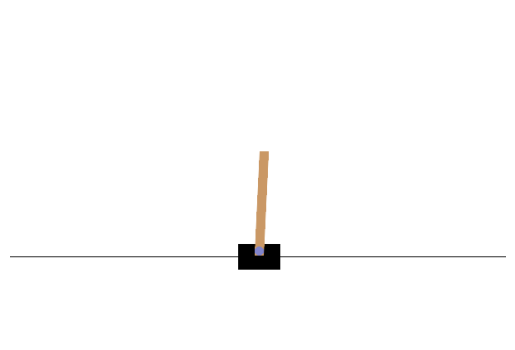

In [2]:
environment = gym.make('CartPole-v1', render_mode="rgb_array")

_ = environment.reset()
_ = plt.imshow(environment.render())

Agent

In [3]:
import torch
import torch.nn as nn

class Agent(nn.Module):
    def __init__(self, inputs=4, actions=2, hidden=False, neurons=64):
        """
        Agent for reinforcement learning.
        
        Parameters
        ----------
        inputs : int, optional
            Number of inputs.
        actions : int, optional
            Number of actions.
        hidden : int or False, optional
            Number of hidden layers.
        neurons : int, optional
            Number of neurons between layers.
        """
        super(Agent, self).__init__()
        self.hidden = hidden
        
        self.layer_in = nn.Linear(inputs, neurons)
        
        if self.hidden:
            for i in range(self.hidden):
                setattr(self, f"layer_{i+1}", nn.Linear(neurons, neurons))
            
        self.layer_out = nn.Linear(neurons, actions)
        
    def forward(self, x):
        """
        Forward pass.
        
        Parameters
        ----------
        x : numpy.ndarray or torch.Tensor
            Observation state.
            
        Returns
        -------
        output : torch.Tensor
            Action probabilities.
        """
        _output = torch.relu(self.layer_in(x))
        
        if self.hidden:
            for i in range(self.hidden):
                _output = torch.relu(getattr(self, f"layer_{i+1}")(_output))
            
        if self.layer_out.out_features > 1:
            output = torch.log_softmax(self.layer_out(_output), dim=-1)
        else:
            output = torch.sigmoid(self.layer_out(_output))
        
        return output

Additions

Asking GitHub Copilot Chat: "Are there any additional steps I can take to speed up training?"

It answered that experience replay is a good idea – and gave me the following code. I also 
implemented a loss function using the memory and Q-learning.

In [4]:
import random
from collections import deque

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Training

In [19]:
EPISODES = 1000
BATCH_SIZE = 64
DISCOUNT = 0.95

agents = {"2-hidden-128-neurons": Agent(inputs=4, actions=2, hidden=2, neurons=128)}

loss_function = nn.MSELoss()
memory = ReplayMemory(10000)

for description, agent in agents.items():
    
    print(f"Training agent '{description}'...")
    
    optimizer = torch.optim.RMSprop(agent.parameters(), 
                                    lr=0.00025, eps=0.01)
    
    for episode in range(EPISODES):
        
        observation, info = environment.reset()
        observation = torch.tensor(observation, dtype=torch.float32)
        
        for step in range(1000):
            
            actions = agent(observation)

            if agent.layer_out.out_features > 1:
                action = actions.argmax().item()
            else:
                action = int(actions.round().item())
            
            next_observation, reward, terminated, truncated, _ = environment.step(action)
            next_observation = torch.tensor(next_observation, dtype=torch.float32)
            finished = terminated or truncated
            
            memory.push((observation, action, reward, next_observation, finished))
            observation = next_observation
            
            if len(memory) < BATCH_SIZE:
                continue
                
            # Sample a batch of transitions
            transitions = memory.sample(BATCH_SIZE)
            
            # Unpack transitions
            state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*transitions)
            
            # Convert to tensors
            state_batch = torch.stack(state_batch)
            action_batch = torch.tensor(action_batch, dtype=torch.long)
            reward_batch = torch.tensor(reward_batch, dtype=torch.int)
            next_state_batch = torch.stack(next_state_batch)
            done_batch = torch.tensor(done_batch, dtype=torch.bool)
            
            # Compute Q-values for the current and next states as well as the expected Q-values
            state_action_values = agent(state_batch).gather(1, action_batch.unsqueeze(-1)).squeeze(-1)
            next_state_values = agent(next_state_batch).max(1)[0].detach()
            expected_state_action_values = reward_batch + (next_state_values * DISCOUNT * 
                                                           ~done_batch)
            
            # Compute the loss
            loss = loss_function(state_action_values, expected_state_action_values)
            
            # Backpropagate the loss and update the weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if finished:
                observation, _ = environment.reset()
                observation = torch.tensor(observation, dtype=torch.float32)
                
    print(f"Agent '{description}' trained.")

Training agent '2-hidden-128-neurons'...
Agent '2-hidden-128-neurons' trained.


1
1
1
1
1
1
1
1
1


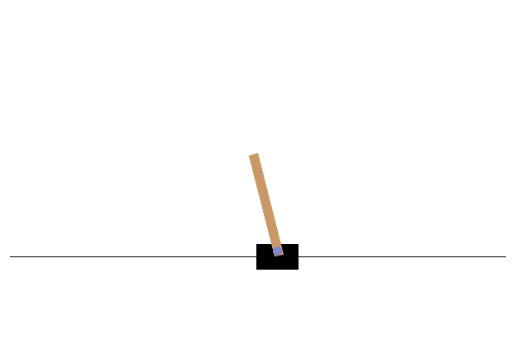

In [22]:
# Use the agent to play the game and save the frames.

observation, info = environment.reset()

for timestep in range(1000):
    
    observation = torch.tensor(observation, dtype=torch.float32)
    actions = agents['2-hidden-128-neurons'](observation)
    action = actions.argmax().item()
    
    print(action)
    
    observation, reward, terminated, truncated, _ = environment.step(action)
    
    _ = plt.imshow(environment.render())
    plt.savefig(f"./images/cart-pole/{timestep}.png")
    
    if terminated or truncated:
        break

In [ ]:
environment.close()

Sources

https://gymnasium.farama.org/content/basic_usage/

https://gymnasium.farama.org/environments/classic_control/cart_pole/

https://ieeexplore.ieee.org/document/6313077